In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import numpy as np
import seaborn as sns
import torch
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
plt.style.use('dark_background')
import data
from skorch.callbacks import Checkpoint
from skorch import NeuralNetRegressor
from config import *
from tqdm import tqdm
import pickle as pkl
import train_reg
from math import floor
from copy import deepcopy
import config
import models
import pandas as pd
import features
from scipy.stats import skew, pearsonr
import outcomes
import neural_networks
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.nn import functional as F
import acd
from acd.scores import cd_propagate

# prepare data

In [2]:
# currently trained only on 'clath_aux+gak_a7d2_new'
dsets = ['clath_aux+gak_new']
splits = ['test']
#feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))
              #['mean_total_displacement', 'mean_square_displacement', 'lifetime']
meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized']
dfs = {}
for dset in tqdm(dsets):
    for split in splits:
        df = data.get_data(dset=dset)
        df = df[~(df.short | df.long | df.hotspots)]
#         df = df[df.valid]
        df = df[df.lifetime > 15] # only keep hard tracks
        df = df[df.cell_num.isin(config.DSETS[dset][split])] # exclude held-out test data
        feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))

        # downsample tracks
        length = 40
        df['X_same_length'] = [features.downsample(df.iloc[i]['X'], length)
                               for i in range(len(df))] # downsampling
        # normalize tracks
        df = features.normalize_track(df, track='X_same_length', by_time_point=False)

        # regression response
        df = train_reg.add_sig_mean(df)     

        # remove extraneous feats
        # df = df[feat_names + meta]
#         df = df.dropna() 

        # normalize features
        for feat in feat_names:
            if 'X_same_length' not in feat:
                df = features.normalize_feature(df, feat)

        dfs[(dset, split)] = deepcopy(df)

# load model
results = pkl.load(open('../models/dnn_full_long_normalized_across_track_1_feat.pkl', 'rb'))
# results = pkl.load(open('../models/clath_aux+gak_a7d2_new_Y_sig_mean_normalized_nn_lstm_100_40.pkl', 'rb'))
dnn = neural_networks.neural_net_sklearn(D_in=40, H=20, p=0, arch='lstm')
dnn.model.load_state_dict(results['model_state_dict'])

100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


<All keys matched successfully>

# important features

In [217]:
# df = dfs[('clath_aux+gak_a7d2', 'train')]
df = dfs[('clath_aux+gak_new', 'test')]
X = df[feat_names]
y = df['y_consec_thresh']
acc_orig = np.mean((dnn.predict(X) > 0) == y)
np.random.seed(13)

In [ ]:
imps = {feat_name: [] for feat_name in feat_names}
reps = 3
for feat_name in tqdm(feat_names):
    for r in range(reps):
        X_copy = deepcopy(X)
        X_copy[feat_name] = np.random.permutation(X_copy[feat_name].values)
        acc = np.mean((dnn.predict(X_copy) > 0) == y)
        imps[feat_name].append(acc_orig - acc)
100 * pd.DataFrame.from_dict(imps).mean().sort_values(ascending=False)

## segmentation

In [3]:
def calc_cd_score(xtrack_t, xfeats_t, start, stop, model):
    
    with torch.no_grad():
        rel, irrel = cd_propagate.propagate_lstm(xtrack_t.unsqueeze(-1), dnn.model.lstm, start=start, stop=stop, my_device='cpu')
    rel = rel.squeeze(1)
    irrel = irrel.squeeze(1)
    rel, irrel = cd_propagate.propagate_conv_linear(rel, irrel, dnn.model.fc)
    #return rel.item()
    return rel.data.numpy()

def plot_segs(track_segs, cd_scores, xtrack, pred, y):
    cm = sns.diverging_palette(22, 220, as_cmap=True, center='light')
    vabs = np.max(np.abs(cd_scores))
    #vabs = 1.2
    # plt.plot(xtrack, zorder=0, lw=2, color='#111111')
    for i in range(len(track_segs)):
        (s, e) = track_segs[i]
        cd_score = cd_scores[i]
        seq_len = e - s
        xs = np.arange(s, e)
        norm = matplotlib.colors.Normalize(vmin=-vabs, vmax=vabs)
        if seq_len > 1:
            cd_score = [cd_score] * seq_len
            plt.plot(xs, xtrack[s: e], zorder=0, lw=2, color=cm(norm(cd_score[0])), alpha=0.5)
        plt.scatter(xs, xtrack[s: e],
                    c=cd_score, cmap=cm, vmin=-vabs, vmax=vabs, s=6)
    plt.title(f"Pred: {pred: .1f}, y: {y}", fontsize=24)
    plt.colorbar(label='CD Score')
    
def max_abs_sum_seg(scores_list, min_length=1):
    
    """
    score_list[i][j] is the score for the segment from i to j (inclusive)
    """
    
    n = len(scores_list[0])
    res = [0]*n
    paths = {}
    for s in range(n):
        for e in range(s, n):
            if e - s >= min_length - 1:
                scores_list[s][e] = abs(scores_list[s][e])
            else:
                scores_list[s][e] = -10000
    paths[-1] = []
    res[0] = scores_list[0][0]
    paths[0] = [0]
    for i in (range(1, n)):
        cand = [res[j-1] + scores_list[j][i] for j in range(i + 1)]
        seg_start = np.argmax(cand)
        res[i] = max(cand)
        paths[i] = paths[seg_start - 1] + [seg_start]
    return res, paths

In [5]:
track_name = 'X_same_length_normalized'
track_name_unnormalized = 'X_same_length'
df = dfs[('clath_aux+gak_new', 'test')]
x = df[feat_names[:1]]
y = df['y_consec_thresh']
m = 40
xtrack_unnormalized = df[track_name_unnormalized]
xtrack = x[track_name]
xtrack_t = torch.tensor(np.array(list(xtrack.values)), dtype=torch.float)
xfeats = x[[c for c in x.columns if c != track_name]]
xfeats_t = torch.tensor(np.array(xfeats).astype(float), dtype=torch.float)


In [6]:
#all_cd_scores = {}
cd_score_path = f'results/all_cd_scores_clath_aux+gak_new_test.pkl'
if os.path.exists(cd_score_path):
    all_cd_scores = pd.read_pickle(cd_score_path)
else:
    for s in tqdm(range(m)):
        for e in range(s+1, m+1):
            all_cd_scores[(s, e)] = calc_cd_score(xtrack_t, xfeats_t, s, e, dnn.model)
    with open(cd_score_path, 'wb') as handle:
        pkl.dump(all_cd_scores, handle, protocol=pkl.HIGHEST_PROTOCOL)

In [9]:
all_res = []
for i in range(len(x)):
    cd_scores_list = np.zeros((m, m))
    for s in (range(m)):
        for e in range(s + 1, m + 1):            
            cd_scores_list[s][e-1] = all_cd_scores[(s, e)][i]
    res, paths = max_abs_sum_seg(cd_scores_list, min_length=2)
    lt = np.sum(np.array(df[track_name_unnormalized].values[i]) != 0)
    #all_res.append(paths[lt-1])
    all_res.append(paths[m - 1])
    #print(res[lt-1], paths[lt-1])

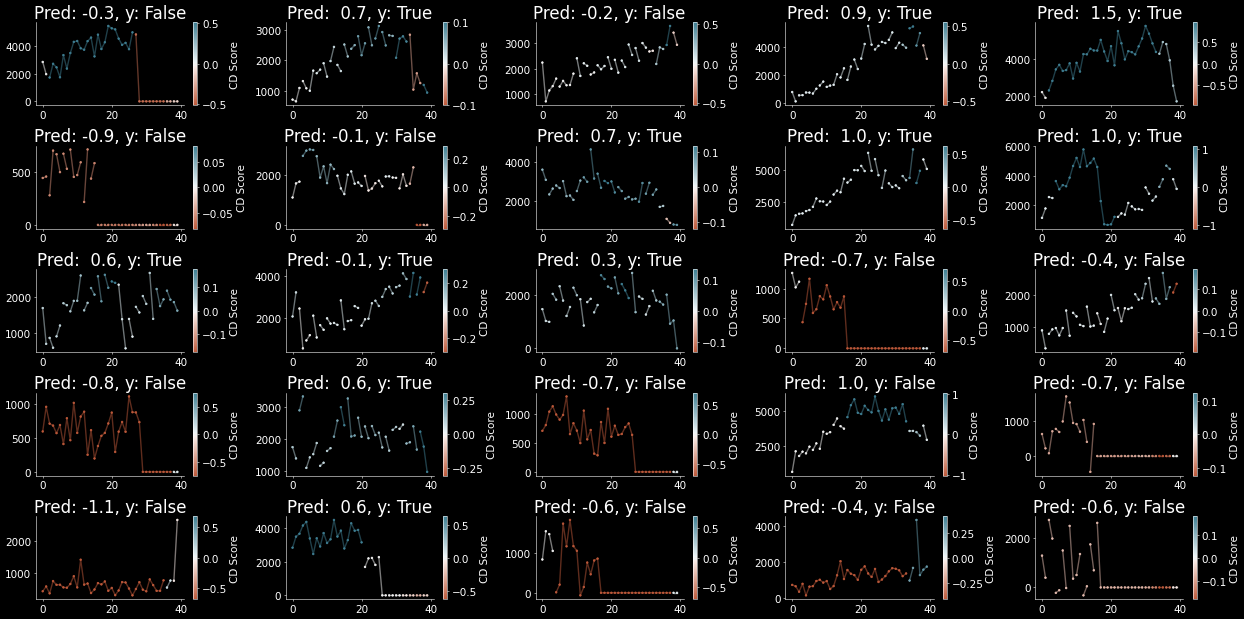

In [13]:
C, R = 5, 5
plt.figure(dpi=50, figsize=(5 * C, 2.5 * R))
for i in range(75, 100):
    ax = plt.subplot(R, C, i - 75 + 1)
    segs = [(all_res[i][j], all_res[i][j+1]) for j in range(len(all_res[i])-1)] + [(all_res[i][-1], 40)]
    scores = [all_cd_scores[(s, e)][i][0] for (s, e) in segs]
    plot_segs(track_segs=segs, cd_scores=scores, xtrack=xtrack_unnormalized.iloc[i],
              pred=dnn.predict(x)[i],
              y=y.values[i])
plt.tight_layout()
plt.show()

In [244]:
with open(f'results/all_cd_scores_clath_aux+gak_new_test.pkl', 'wb') as handle:
    pkl.dump(all_cd_scores, handle, protocol=pkl.HIGHEST_PROTOCOL)

In [ ]:
all_cd_scores_normalized = {}
for s in tqdm(range(m)):
    for e in range(s + 1, m + 1):
        x = all_cd_scores[(s, e)]
        x = x.reshape(1, -1)[0]
        all_cd_scores_normalized[(s, e)] = np.abs((x - np.mean(x))/np.std(x))
        
for i in range(len(df)):
    cd_scores_list = np.zeros((m, m))
    s0, e0 = 0, 0
    m = 0
    lt = np.sum(np.array(df[track_name_unnormalized].values[i]) != 0)
    for s in (range(lt)):
        for e in range(s+1, lt):            
            cd_scores_list[s][e-1] = all_cd_scores_normalized[(s, e)][i]
            if cd_scores_list[s][e-1] > m:
                m = cd_scores_list[s][e-1]
                s0, e0 = s, e

# interpret one pred

In [170]:
def calc_cd_score(start, stop, model):
    mask = torch.zeros(xfeats_t.shape)
    mask[start: stop] = 1
    rel_feats = mask * xfeats_t
    irrel_feats = xfeats_t - rel_feats
    with torch.no_grad():
        rel, irrel = cd_propagate.propagate_lstm(xtrack_t.unsqueeze(-1), dnn.model.lstm, start=start, stop=stop, my_device='cpu')
    rel = rel.squeeze(1)
    irrel = irrel.squeeze(1)
    h_rel = torch.cat((rel, rel_feats), 1)
    h_irrel = torch.cat((irrel, irrel_feats), 1)
    rel, irrel = cd_propagate.propagate_conv_linear(h_rel, h_irrel, dnn.model.fc)
    #return rel.item()
    return rel.data.numpy()

def plot_segs(track_segs, cd_scores, xtrack, pred):
    cm = sns.diverging_palette(22, 220, as_cmap=True, center='light')
    vabs = np.max(np.abs(cd_scores))
    # plt.plot(xtrack, zorder=0, lw=2, color='#111111')
    for i in range(len(track_segs)):
        (s, e) = track_segs[i]
        cd_score = cd_scores[i]
        seq_len = e - s
        xs = np.arange(s, e)
        norm = matplotlib.colors.Normalize(vmin=-vabs, vmax=vabs)
        if seq_len > 1:
            cd_score = [cd_score] * seq_len
            plt.plot(xs, xtrack[s: e], zorder=0, lw=2, color=cm(norm(cd_score[0])), alpha=0.5)
        plt.scatter(xs, xtrack[s: e],
                    c=cd_score, cmap=cm, vmin=-vabs, vmax=vabs, s=6)

In [171]:
track_name = 'X_same_length_normalized'
track_name_unnormalized = 'X_same_length'
num = 100
x = X.iloc[num: num + 1]
xtrack_unnormalized = df.iloc[num: num + 1][track_name_unnormalized]
xtrack = x[track_name]
xtrack_t = torch.tensor(np.array(list(xtrack.values)), dtype=torch.float)
xfeats = x[[c for c in x.columns if c != track_name]]
xfeats_t = torch.tensor(np.array(xfeats).astype(float), dtype=torch.float)
#pred = dnn.model(xtrack_t, xfeats_t).item()
#print(f'pred {pred:0.2f}')

In [6]:
T = 40 # seq len
# track_segs = [(s, s + 1) for s in range(T)]
DIV = 40
track_segs_fourty = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]

DIV = 20
track_segs_twenty = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
DIV = 10
track_segs_tenths = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
DIV = 6
track_segs_fifths = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
DIV = 4
track_segs_quarters = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
DIV = 1
track_segs_full = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
track_segs_list = [track_segs_fourty, track_segs_twenty, track_segs_tenths,
                   track_segs_fifths, track_segs_quarters, track_segs_full]
cd_scores_list = [[calc_cd_score(s, e, dnn.model)
                  for (s, e) in track_segs]
                  for track_segs in tqdm(track_segs_list)]

100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


In [ ]:
plt.figure(dpi=200, figsize=(12, 6))
R, C = 2, 3
for i, track_segs in enumerate(track_segs_list):
    ax = plt.subplot(R, C, i + 1)
    cd_scores = cd_scores_list[i]
    plot_segs(track_segs, cd_scores, xtrack_unnormalized.iloc[0], pred)
    
    if i == C * (R - 1):
        plt.xlabel('Time')
    else:
        plt.xticks([])
    if i == 0:
        plt.ylabel('Clath Amplitude')
    else:
        plt.yticks([])
    if i  == C - 1:
        plt.colorbar(label='CD Score')
    else:
        plt.colorbar()
    if i ==  C * R - 1:
        plt.text(0.6, 0.9,
                 f'Pred: {pred:.2f}', fontsize='x-large', transform = ax.transAxes)
plt.tight_layout()
plt.show()

# transformation importance

In [ ]:
import torch
import torch.nn as nn
from trim.trim import TrimModel
from functools import partial

# setup a trim model
model = dnn.model
transform = partial(torch.rfft, signal_ndim=1, onesided=False) # fft
inv_transform = partial(torch.irfft, signal_ndim=1, onesided=False) # inverse fft
model_trim = TrimModel(model=model, inv_transform=inv_transform) # trim model

# get a data point
x = torch.randn(1, 10)
s = transform(x)

# can now use any attribution method on the trim model
# get (input_x_gradient) attribution in the fft space
s.requires_grad = True
model_trim(s).backward()
input_x_gradient = s.grad * s